## Imports et Configuration

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import numpy as np
from PIL import Image
import time
import os
import copy

# Configuration
CONFIG = {
    'img_size': 224,
    'embed_dim': 128,        # Taille vecteur latent z
    'num_classes': 3,        # 0: Alert, 1: Drowsy, 2: Distracted
    'recursion_depth': 3,    # Nombre d'itérations du TRM (n)
    'batch_size': 16,
    'lr': 1e-4,
    'epochs': 100,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'save_path': 'best_trm_model.pth'
}

print(f"Utilisation du device : {CONFIG['device']}")

Utilisation du device : cuda


### # ARCHITECTURE MOBILE-TRM (FULL FINE-TUNING)

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models

class PretrainedVisualEmbedding(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        # 1. MobileNetV3 Small (Poids par défaut)
        self.backbone = models.mobilenet_v3_small(weights='DEFAULT')
        self.features = self.backbone.features
        
        # IMPORTANT : ON DÉGÈLE TOUT
        # Cela permet au CNN d'apprendre les spécificités de vos images (N&B, IR)
        for param in self.features.parameters():
            param.requires_grad = True 
            
        # 3. Adaptateur 576 canaux -> 128
        self.adapter = nn.Sequential(
            nn.Conv2d(576, output_dim, 1),
            nn.BatchNorm2d(output_dim),
            nn.ReLU6()
        )
        self.pool = nn.AdaptiveAvgPool2d((8, 8))

    def forward(self, x):
        x = self.features(x)
        x = self.adapter(x)
        x = self.pool(x)
        B, C, H, W = x.shape
        # [B, 128, 8, 8] -> [B, 64, 128]
        x = x.view(B, C, -1).permute(0, 2, 1)
        return x

class AttentionTRMBlock(nn.Module):
    def __init__(self, embed_dim, num_classes, num_heads=4):
        super().__init__()
        self.attn_norm = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads=num_heads, batch_first=True)
        self.ffn_norm = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.GELU(),
            nn.Linear(embed_dim * 2, embed_dim)
        )
        self.head = nn.Linear(embed_dim, num_classes)
        # Gating pour forcer l'apprentissage visuel
        self.gate = nn.Parameter(torch.tensor([1.0])) 

    def forward(self, tokens, z_prev):
        g = torch.sigmoid(self.gate)
        z_curr = z_prev + g * tokens
        z_norm = self.attn_norm(z_curr)
        attn_out, attn_weights = self.attn(z_norm, z_norm, z_norm, average_attn_weights=False)
        z_curr = z_curr + attn_out
        z_curr = z_curr + self.ffn(self.ffn_norm(z_curr))
        # Classification sur le token [CLS] (indice 0)
        return z_curr, self.head(z_curr[:, 0, :]), attn_weights

class DriverTRM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = PretrainedVisualEmbedding(config['embed_dim'])
        
        # Token CLS + Position
        self.cls_token = nn.Parameter(torch.randn(1, 1, config['embed_dim']) * 0.02)
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + 64, config['embed_dim']) * 0.02)
        
        self.trm_block = AttentionTRMBlock(config['embed_dim'], config['num_classes'])
        
    def forward(self, img):
        B = img.size(0)
        x_feat = self.embedding(img) # [B, 64, 128]
        
        cls_tokens = self.cls_token.expand(B, -1, -1)
        tokens = torch.cat([cls_tokens, x_feat], dim=1) # [B, 65, 128]
        tokens = tokens + self.pos_embed
        
        z_curr = torch.zeros_like(tokens).to(img.device)
        outputs_list = []
        
        for _ in range(self.config['recursion_depth']):
            z_curr, logits, attn = self.trm_block(tokens, z_curr)
            outputs_list.append(logits)
            
        return outputs_list, attn

### Téléchargement et Préparation des Données

In [3]:
import kagglehub
import os

def download_and_prepare_annotations_final():
    print("--- Téléchargement & Parsing (Format Custom) ---")
    path = kagglehub.dataset_download("zeyad1mashhour/driver-inattention-detection-dataset")
    
    all_image_paths = []
    all_labels = [] 
    
    # MAPPING EXACT basé sur le fichier _annotations.txt
    # 0: Alert, 1: Drowsy, 2: Distracted
    id_map = {
        0: 2, # Dangerous -> Distracted
        1: 2, # Distracted -> Distracted
        2: 2, # Drinking -> Distracted
        3: 0, # Safe -> Alert
        4: 1, # Sleepy -> Drowsy
        5: 1  # Yawn -> Drowsy
    }
    
    seen = set() # Pour éviter les doublons

    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('_annotations.txt'):
                annot_path = os.path.join(root, file)
                try:
                    with open(annot_path, 'r') as f:
                        lines = f.readlines()
                        
                    for line in lines:
                        parts = line.strip().split(' ')
                        if len(parts) >= 2:
                            filename = parts[0]
                            # Le format est "image.jpg x,y,w,h,ID"
                            # On récupère l'ID tout à la fin
                            try:
                                cls_id = int(parts[1].split(',')[-1])
                                if cls_id in id_map:
                                    img_path = os.path.join(root, filename)
                                    if os.path.exists(img_path) and img_path not in seen:
                                        all_image_paths.append(img_path)
                                        all_labels.append(id_map[cls_id])
                                        seen.add(img_path)
                            except: continue
                except Exception as e:
                    print(f"Erreur lecture {file}: {e}")

    print(f"Total images chargées : {len(all_image_paths)}")
    return all_image_paths, all_labels

# Exécution
image_paths, labels = download_and_prepare_annotations_final()

d:\Developpement web\TRM\Driver Drowsiness Edge AI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Téléchargement & Parsing (Format Custom) ---
Total images chargées : 14855


### Le Dataset PyTorch Réel (Fusionné)

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as T

class RealDriverDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            # Chargement de l'image (RGB)
            img = Image.open(img_path).convert('RGB')
            
            if self.transform:
                img = self.transform(img)
                
            return img, torch.tensor(label, dtype=torch.long)
            
        except Exception as e:
            # Gestion basique des erreurs (fichier corrompu)
            print(f"Erreur chargement {img_path}: {e}")
            # Retourner une image noire factice pour ne pas planter le batch
            return torch.zeros((3, 64, 64)), torch.tensor(label, dtype=torch.long)

# --- Configuration des Transformations (Data Augmentation) ---
# Essentiel pour homogénéiser State Farm (Corps entier) et Eye Dataset (Gros plan)
def get_transforms(phase='train'):
    if phase == 'train':
        return T.Compose([
            T.Resize((128, 128)),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(15),
            T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4), # Plus fort pour casser les biais de lumière
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            # Random Erasing
            # Efface un rectangle aléatoire avec une proba de 20%
            T.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3))
        ])
    else:
        return T.Compose([
            T.Resize((128, 128)), # CHANGE : 128x128
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

### Création des DataLoaders avec les Vraies Données

In [5]:
# 1. Instanciation du Dataset complet avec les données téléchargées plus haut
# image_paths et labels proviennent de votre fonction download_and_prepare_data()
full_dataset = RealDriverDataset(
    image_paths, 
    labels, 
    transform=get_transforms('train') # On applique les augmentations (rotation, bruit, etc.)
)

print(f"Dataset créé avec {len(full_dataset)} images.")

# 2. Division Train / Validation (80% Train, 20% Val)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# generator=torch.Generator().manual_seed(42) assure que le split est toujours le même
train_ds, val_ds = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print(f"Images d'entraînement : {len(train_ds)}")
print(f"Images de validation : {len(val_ds)}")

# 3. Création des DataLoaders (Ce sont eux que 'train_model' va appeler)
# num_workers > 0 permet de charger les images en parallèle pour ne pas ralentir le GPU
# pin_memory=True accélère le transfert vers le GPU (cuda)
train_loader = DataLoader(
    train_ds, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True, 
    num_workers=0, 
    pin_memory=True
)

val_loader = DataLoader(
    val_ds, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False, 
    num_workers=0, 
    pin_memory=True
)

print("DataLoaders prêts !")

Dataset créé avec 14855 images.
Images d'entraînement : 11884
Images de validation : 2971
DataLoaders prêts !


### Entraînement ADAPTÉ AU MULTI-HEAD ATTENTION & Checkpointing

In [6]:
import torch.optim as optim
import time
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import Counter

# --- 1. Fonctions Utilitaires ---

def calculate_entropy(probs):
    """
    Calcule l'incertitude moyenne (Entropie de Shannon).
    Plus c'est bas, plus le modèle est sûr de lui.
    """
    epsilon = 1e-8
    entropy = -torch.sum(probs * torch.log(probs + epsilon), dim=1)
    return entropy.mean().item()

def deep_supervision_loss(outputs_list, targets, criterion):
    """
    Moyenne de la loss sur toutes les étapes de récursion.
    Aide le modèle à converger plus vite au début.
    """
    total_loss = 0
    # On peut pondérer : donner plus d'importance à la dernière sortie
    # weights = [0.1, 0.2, 0.3, 0.4] (si recursion=4)
    # Ici on fait une moyenne simple pour commencer
    for output in outputs_list:
        total_loss += criterion(output, targets)
    return total_loss / len(outputs_list)

def attention_entropy_loss(attn_weights, lambda_ent=0.01):
    """
    Pénalise l'incertitude dans l'attention CLS->Patches.
    Force le modèle à choisir une zone précise (Pic d'attention).
    """
    # attn_weights: [B, Heads, L, L] -> On prend ligne CLS (0) vers Patches (1:)
    probs = attn_weights[:, :, 0, 1:]
    probs = probs.clamp(min=1e-9)
    entropy = -(probs * probs.log()).sum(dim=-1).mean()
    return lambda_ent * entropy

# --- 2. Boucle d'Entraînement Complète ---

def train_model():
    print(f"🚀 Démarrage de l'entraînement (MobileNet + TRM) sur {CONFIG['device']}...")
    
    # 1. Calcul des poids de classe (Crucial pour l'équilibre Safe/Drowsy)
    # On récupère tous les labels du dataset d'entraînement pour compter
    all_train_labels = [label.item() for _, label in train_ds]
    counts = Counter(all_train_labels)
    total_samples = sum(counts.values())
    
    # Poids = Total / (Nombre de classes * Nombre d'occurences)
    class_weights = [total_samples / (CONFIG['num_classes'] * counts[i]) for i in range(CONFIG['num_classes'])]
    class_weights_tensor = torch.FloatTensor(class_weights).to(CONFIG['device'])
    
    print(f"⚖️ Poids des classes appliqués : {class_weights}")
    
    # 2. Instanciation
    model = DriverTRM(CONFIG).to(CONFIG['device'])
    
    # LR un peu plus bas car on utilise un Backbone pré-entraîné
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
    
    # On intègre les poids ici
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3
    )
    
    # Historique complet (Ce que vous vouliez loger)
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_entropy': []}
    
    best_val_f1 = 0.0
    start_time = time.time()

    print(f"{'Epoch':^7} | {'Train Loss':^10} | {'Val Loss':^8} | {'Val Acc':^8} | {'Val F1':^8} | {'Entropy':^7} | {'LR':^7}")
    print("-" * 95)

    for epoch in range(CONFIG['epochs']):
        # --- TRAIN ---
        model.train()
        running_loss = 0.0
        
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(CONFIG['device']), labels.to(CONFIG['device'])
            optimizer.zero_grad()
            
            # Forward
            outputs_list, attn_weights = model(imgs)
            
            # Loss = Classification (Deep Supervision) + Focus (Entropie Attention)
            loss_main = deep_supervision_loss(outputs_list, labels, criterion)
            loss_attn = attention_entropy_loss(attn_weights, lambda_ent=0.05)
            
            loss = loss_main + loss_attn
             
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        avg_train_loss = running_loss / len(train_loader)
        
        # --- VALIDATION ---
        model.eval()
        val_loss = 0.0
        val_entropy_sum = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(CONFIG['device']), labels.to(CONFIG['device'])
                
                outputs_list, _ = model(imgs)
                
                # Loss Val
                loss = deep_supervision_loss(outputs_list, labels, criterion)
                val_loss += loss.item()
                
                # Métriques sur la dernière itération
                final_logits = outputs_list[-1]
                probs = F.softmax(final_logits, dim=1)
                
                # Entropie (Incertitude du modèle)
                val_entropy_sum += calculate_entropy(probs)
                
                preds = torch.argmax(final_logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_entropy = val_entropy_sum / len(val_loader)
        
        # Métriques Sklearn
        val_acc = np.mean(np.array(all_preds) == np.array(all_labels))
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        
        # Scheduler
        scheduler.step(val_f1)
        current_lr = optimizer.param_groups[0]['lr']
        
        # --- LOGGING DANS L'HISTORIQUE ---
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_entropy'].append(avg_val_entropy)
        
        save_msg = ""
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), CONFIG['save_path'])
            save_msg = "--> ⭐ Saved!"
            
        print(f"{epoch+1:^7} | {avg_train_loss:^10.4f} | {avg_val_loss:^8.4f} | {val_acc:^8.4f} | {val_f1:^8.4f} | {avg_val_entropy:^7.4f} | {current_lr:.1e} {save_msg}")

    print("\nEntraînement terminé.")
    return model, history, all_labels, all_preds

# Lancement
trained_model, history, y_true, y_pred = train_model()

🚀 Démarrage de l'entraînement (MobileNet + TRM) sur cuda...
⚖️ Poids des classes appliqués : [0.8012405609492989, 3.164004259850905, 0.6964369432723863]
 Epoch  | Train Loss | Val Loss | Val Acc  |  Val F1  | Entropy |   LR   
-----------------------------------------------------------------------------------------------
   1    |   1.0035   |  0.7069  |  0.8307  |  0.8322  | 0.6525  | 1.0e-04 --> ⭐ Saved!
   2    |   0.7038   |  0.6707  |  0.8428  |  0.8458  | 0.6904  | 1.0e-04 --> ⭐ Saved!
   3    |   0.6368   |  0.6421  |  0.8600  |  0.8634  | 0.6411  | 1.0e-04 --> ⭐ Saved!
   4    |   0.6121   |  0.6362  |  0.8798  |  0.8814  | 0.5712  | 1.0e-04 --> ⭐ Saved!
   5    |   0.5982   |  0.6109  |  0.8893  |  0.8916  | 0.6177  | 1.0e-04 --> ⭐ Saved!
   6    |   0.5910   |  0.6031  |  0.9034  |  0.9043  | 0.5471  | 1.0e-04 --> ⭐ Saved!
   7    |   0.5792   |  0.6005  |  0.8909  |  0.8943  | 0.5929  | 1.0e-04 
   8    |   0.5664   |  0.5873  |  0.9155  |  0.9163  | 0.6014  | 1.0e-04 --> ⭐ 

### Affichage des Résultats et Plots

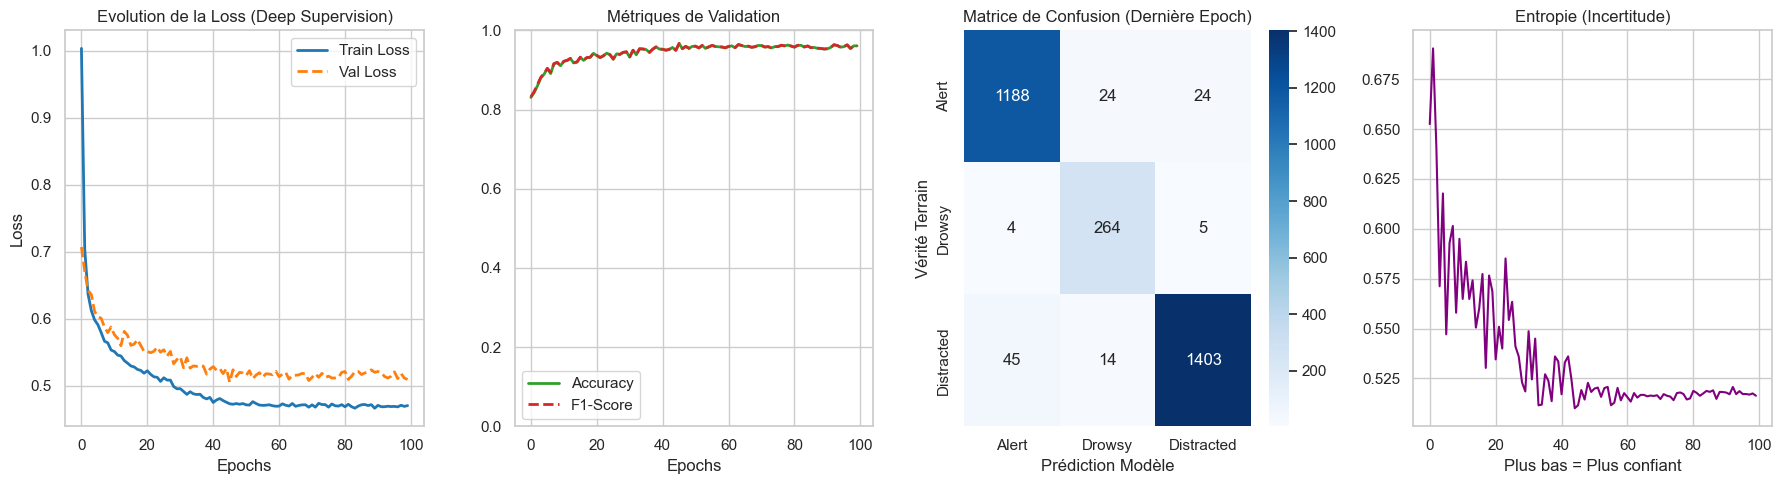


--- Rapport de Classification ---
              precision    recall  f1-score   support

       Alert       0.96      0.96      0.96      1236
      Drowsy       0.87      0.97      0.92       273
  Distracted       0.98      0.96      0.97      1462

    accuracy                           0.96      2971
   macro avg       0.94      0.96      0.95      2971
weighted avg       0.96      0.96      0.96      2971



In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_results(history, y_true, y_pred, classes=['Alert', 'Drowsy', 'Distracted']):
    # CORRECTION : On force la liste des labels attendus [0, 1, 2]
    # Cela évite le crash si une classe est manquante dans les prédictions
    all_labels = range(len(classes)) 

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 4, figsize=(18, 5))
    
    # 1. Courbes de Loss 
    ax[0].plot(history['train_loss'], label='Train Loss', color='tab:blue', linewidth=2)
    ax[0].plot(history['val_loss'], label='Val Loss', color='tab:orange', linewidth=2, linestyle='--')
    ax[0].set_title("Evolution de la Loss (Deep Supervision)")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    
    # 2. Courbes de Métriques (Accuracy & F1)
    ax[1].plot(history['val_acc'], label='Accuracy', color='tab:green', linewidth=2)
    ax[1].plot(history['val_f1'], label='F1-Score', color='tab:red', linewidth=2, linestyle='--')
    ax[1].set_title("Métriques de Validation")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylim(0, 1.0)
    ax[1].legend()
    
    # 3. Matrice de Confusion 
    # AJOUT : paramètre 'labels' pour forcer la matrice 3x3 même si une classe manque
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[2], 
                xticklabels=classes, yticklabels=classes)
    ax[2].set_title("Matrice de Confusion (Dernière Epoch)")
    ax[2].set_ylabel("Vérité Terrain")
    ax[2].set_xlabel("Prédiction Modèle")


    # 4. Entropy
    ax[3].plot(history['val_entropy'], color='purple')
    ax[3].set_title("Entropie (Incertitude)")
    ax[3].set_xlabel("Plus bas = Plus confiant")
    
    plt.tight_layout()
    plt.show()
    
    # Rapport textuel détaillé
    print("\n--- Rapport de Classification ---")
    # AJOUT : paramètres 'labels' et 'zero_division'
    print(classification_report(y_true, y_pred, target_names=classes, labels=all_labels, zero_division=0))

# Afficher les graphiques
plot_results(history, y_true, y_pred)

### Fonction de Visualisation (CLS -> Patches)

In [8]:
def visualize_cls_attention(model, dataset, index=None):
    """
    Visualise l'attention portée par le token [CLS] sur les patches de l'image.
    """
    model.eval()
    if index is None: index = np.random.randint(0, len(dataset))
    
    img_tensor, label = dataset[index]
    
    # Prépare l'image pour affichage
    img_display = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_display = (img_display * 0.229 + 0.485).clip(0, 1)
    img_display = (img_display * 255).astype(np.uint8)
    
    # Inférence
    img_input = img_tensor.unsqueeze(0).to(CONFIG['device'])
    with torch.no_grad():
        _, attn_weights = model(img_input)
        
        # attn_weights: [B, Heads, 17, 17]
        # On veut: CLS (idx 0) -> Patches (idx 1 à 16)
        # On moyenne les têtes pour l'affichage global
        cls_attn = attn_weights[0, :, 0, 1:] # [Heads, 16]
        cls_attn = cls_attn.mean(dim=0)      # [16] (Moyenne sur les têtes)
        
        # Reshape en grille 4x4
        attn_grid = cls_attn.view(8, 8).cpu().numpy()

    # Upscaling pour overlay
    heatmap = cv2.resize(attn_grid, (64, 64), interpolation=cv2.INTER_CUBIC)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    overlay = cv2.addWeighted(cv2.cvtColor(img_display, cv2.COLOR_RGB2BGR), 0.6, heatmap_color, 0.4, 0)
    
    # Affichage
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1); plt.imshow(img_display); plt.title("Originale")
    plt.subplot(1, 2, 2); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title("Attention [CLS]")
    plt.show()

### Visualisation de l'Attention

Exemples de visualisations d'attention :


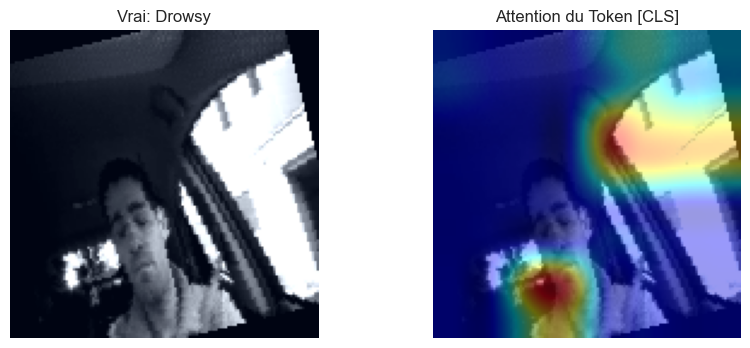

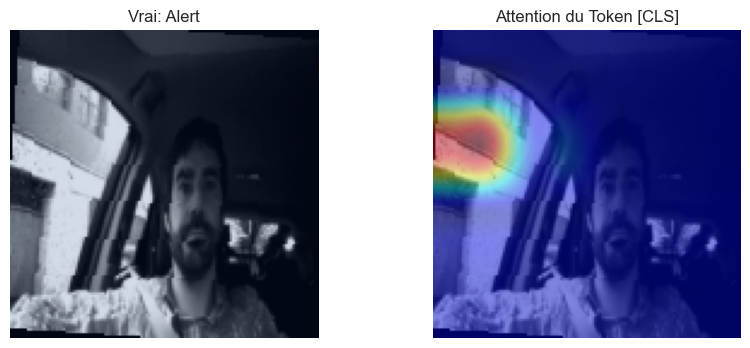

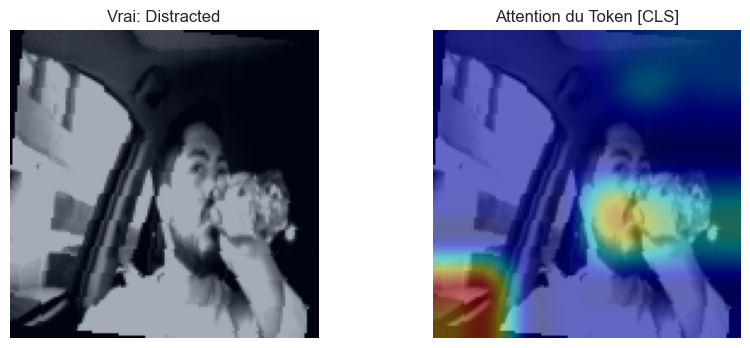

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_attention(model, dataset, index=None):
    model.eval()
    if index is None: index = np.random.randint(0, len(dataset))
    
    img_tensor, label = dataset[index]
    
    # Préparation image pour affichage
    img_display = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_display = (img_display * 0.229 + 0.485).clip(0, 1)
    img_display = (img_display * 255).astype(np.uint8)
    
    img_input = img_tensor.unsqueeze(0).to(CONFIG['device'])
    
    with torch.no_grad():
        # Le modèle retourne (outputs, attn_weights)
        _, attn_weights = model(img_input)
        
        # attn_weights shape est maintenant : [Batch, Heads, 17, 17]
        # (car 1 CLS + 16 Patches = 17 tokens)
        
        # On veut voir ce que le CLS (l'arbitre) regarde dans l'image.
        # Index 0 = CLS. Indices 1: = Les Patches de l'image.
        
        # On prend : Batch 0, Toutes les têtes, Ligne 0 (CLS), Colonnes 1 à fin (Patches)
        cls_attn = attn_weights[0, :, 0, 1:] # Shape [Heads, 16]
        
        # On fait la moyenne sur les têtes d'attention
        cls_attn = cls_attn.mean(dim=0) # Shape [16]
        
        # Maintenant on a bien 16 valeurs qu'on peut remettre en 4x4
        attn_grid = cls_attn.view(8, 8).cpu().numpy()

    # Upscaling et Colorisation
    heatmap = cv2.resize(attn_grid, (128, 128), interpolation=cv2.INTER_CUBIC)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Overlay
    overlay = cv2.addWeighted(cv2.cvtColor(img_display, cv2.COLOR_RGB2BGR), 0.6, heatmap_color, 0.4, 0)
    
    # Affichage
    classes = {0: "Alert", 1: "Drowsy", 2: "Distracted"}
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_display)
    plt.title(f"Vrai: {classes[label.item()]}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Attention du Token [CLS]")
    plt.axis('off')
    plt.show()

# Test
print("Exemples de visualisations d'attention :")
for _ in range(3):
    visualize_attention(trained_model, val_ds)

### Chargement du meilleur modèle pour inférence

In [10]:
def load_best_model():
    print(f"Chargement du meilleur modèle depuis : {CONFIG['save_path']}")
    
    # 1. Recréer l'architecture
    model = DriverTRM(CONFIG)
    
    # 2. Charger les poids
    model.load_state_dict(torch.load(CONFIG['save_path'], map_location=CONFIG['device']))
    model.to(CONFIG['device'])
    model.eval()
    
    print("Modèle chargé avec succès. Prêt pour l'inférence Edge.")
    return model

best_model = load_best_model()

Chargement du meilleur modèle depuis : best_trm_model.pth
Modèle chargé avec succès. Prêt pour l'inférence Edge.


In [11]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        
        # On attache des "hooks" pour récupérer les gradients et les activations
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activation = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        # 1. Forward Pass
        self.model.eval()
        # On doit réactiver les gradients même en eval pour GradCAM
        with torch.set_grad_enabled(True):
            outputs, _ = self.model(x)
            output = outputs[-1] # Dernière sortie de la récursion
            
            if class_idx is None:
                class_idx = torch.argmax(output, dim=1)
            
            # 2. Backward Pass pour la classe cible
            self.model.zero_grad()
            target = output[0, class_idx]
            target.backward()
            
            # 3. Calcul de la Heatmap (Moyenne pondérée des gradients)
            # Gradients: [1, 576, 8, 8] -> Pooled: [1, 576, 1, 1]
            pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
            
            # Activation: [1, 576, 8, 8]
            activation = self.activation[0]
            
            # On pondère chaque canal de l'activation par son gradient
            for i in range(activation.shape[0]):
                activation[i, :, :] *= pooled_gradients[i]
                
            # Moyenne sur les canaux -> [8, 8]
            heatmap = torch.mean(activation, dim=0).cpu().detach().numpy()
            
            # ReLU (on ne garde que les impacts positifs)
            heatmap = np.maximum(heatmap, 0)
            
            # Normalisation
            if np.max(heatmap) != 0:
                heatmap /= np.max(heatmap)
                
            return heatmap, class_idx.item()

Comparaison Grad-CAM vs Attention :


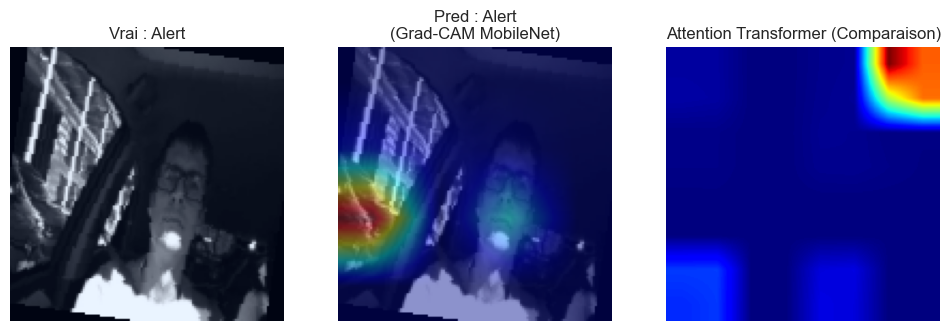

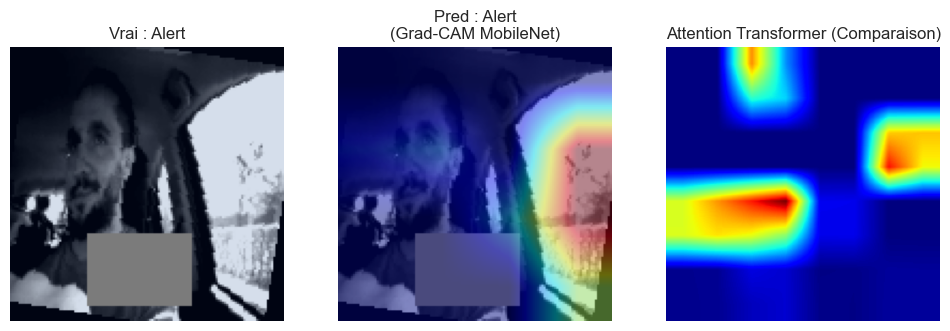

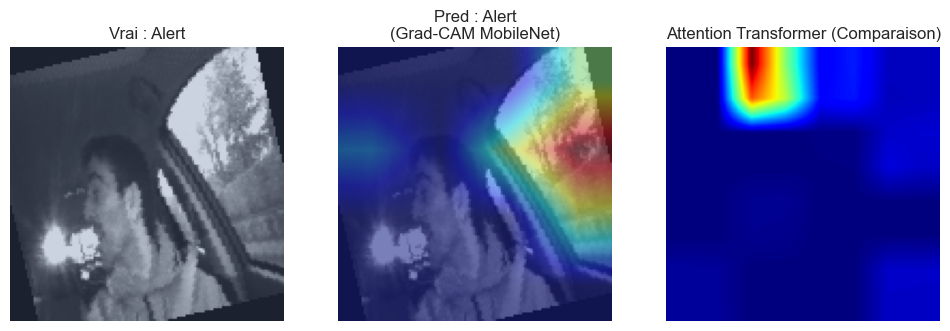

In [12]:
def visualize_gradcam(model, dataset, index=None):
    # 1. Sélection de l'image
    if index is None: index = np.random.randint(0, len(dataset))
    img_tensor, label = dataset[index]
    
    # Préparation input
    input_tensor = img_tensor.unsqueeze(0).to(CONFIG['device'])
    input_tensor.requires_grad = True # Indispensable pour GradCAM
    
    # 2. Ciblage de la couche : On veut la dernière couche du MobileNet
    # Dans votre code : model.embedding.backbone.features[-1]
    target_layer = model.embedding.backbone.features[-1]
    
    # 3. Génération GradCAM
    grad_cam = GradCAM(model, target_layer)
    heatmap, pred_idx = grad_cam(input_tensor)
    
    # 4. Affichage
    # Préparation image originale
    img_disp = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_disp = (img_disp * 0.229 + 0.485).clip(0, 1)
    img_disp = (img_disp * 255).astype(np.uint8)
    
    # Resize heatmap à la taille de l'image (224x224)
    heatmap = cv2.resize(heatmap, (img_disp.shape[1], img_disp.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Superposition
    overlay = cv2.addWeighted(cv2.cvtColor(img_disp, cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)
    
    classes = {0: "Alert", 1: "Drowsy", 2: "Distracted"}
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img_disp)
    plt.title(f"Vrai : {classes[label.item()]}")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Pred : {classes[pred_idx]}\n(Grad-CAM MobileNet)")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    # On affiche l'attention Transformer pour comparer (souvent floue)
    with torch.no_grad():
        _, attn = model(input_tensor)
        cls_attn = attn[0, :, 0, 1:].mean(dim=0).view(8, 8).cpu().numpy()
        cls_attn = cv2.resize(cls_attn, (224, 224))
        plt.imshow(cls_attn, cmap='jet')
    plt.title("Attention Transformer (Comparaison)")
    plt.axis('off')
    
    plt.show()

# TESTEZ CECI MAINTENANT
print("Comparaison Grad-CAM vs Attention :")
# Assurez-vous d'avoir entraîné le modèle 'trained_model' avant
for _ in range(3):
    visualize_gradcam(trained_model, val_ds)